# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

In [8]:
from PIL import Image, ImageTk, ImageMath, ImageOps
Image.MAX_IMAGE_PIXELS = 1000000000
import PIL.ImageGrab as ImageGrab
import cv2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from io import StringIO
from csv import writer 
from scipy import integrate
import math
import time as time_lib
import xarray as xr
import subprocess
import json
from prettytable import *

def current_milli_time():
    return round(time_lib.time() * 1000 *1000)

In [2]:
from A_helper_functions import *

## Launch Segment simulation

In [207]:
a = 217
b = 0.0036

def f(t,rad=False):
    global a, b
    # np.tan(phi)= a - b*t
    phi = np.arctan(b*(a+t))
    if rad: return phi
    else: return np.rad2deg(phi)

In [208]:
# global constants

r_moon = 1737400    # [m] volumetric mean radius of the moon = reference height from heightmap
m_moon = 0.07346e24 # [kg] mass of the moon
G = 6.67430e-11 # Gravitational constant

# for later in simulation
m_full = 0
m_flow = 0
EEV = 0

def deltaV(mass_fuel_used,mass_full,EEV):
    # compute deltaV from used mass of fuel
    dV = EEV * np.log(mass_full / (mass_full-mass_fuel_used))
    return dV

def downrange_distance(pos):
    # known starting point at [ x = 0, y = r_moon ]
    alpha = angle(pos)
    # circular arc = alpha * r
    dist = alpha * r_moon
    return dist

def orbital_velocity(altitude):
    return np.sqrt((G * m_moon)/(r_moon + altitude))

def altitude(pos):
    r = np.linalg.norm(pos)
    return r - r_moon

def vec_from_angle(deg): # in [x,y] cartesian-coordinates
    rad = np.deg2rad(90-deg)

    y = np.sin(rad)
    x = np.cos(rad)
    vec = np.array([x,y,0], dtype=np.float64)
    
    return vec

def angle(vec,v_ref=None,rad=False):
    
    if v_ref is not None:
        vector_1 = v_ref
    else:
        vector_1 = [0, 1, 0]
    vector_2 = vec
    
    if np.linalg.norm(vector_2) == 0: return None

    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    
    if vec[0]<0:
        angle = 2*np.pi - angle
    
    if rad: return angle
    return np.rad2deg(angle)

def r_sys(vec, pos):

    alpha = angle(pos,rad=True)
    rot = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
    v = np.array([vec[0], vec[1]], dtype=np.float64)
    v2 = np.dot(rot, v)
    r_vec = np.array([v2[0], v2[1], vec[2]], dtype=np.float64)

    return r_vec

def rel_sys(vec, pos):

    e_r = pos / np.linalg.norm(pos)
    e_phi = np.cross(e_r, [0, 0, 1])
    
    rel_vec = vec[0]*e_phi + vec[1]*e_r

    return rel_vec

def log(csv_writer,time,pos,vel,acc,m,dir_n):
    x = 1
    # logging results only every x seconds
    if (time*1000)%(x) == 0:
        write_data_row(csv_writer,time,pos,vel,acc,m,dir_n)
         
def write_data_row(csv_writer,time,pos,vel,acc,m,dir_n):
    csv_writer.writerow([time,m,altitude(pos),pos[0],pos[1],pos[2],r_sys(vel,pos)[1],r_sys(vel,pos)[0],vel[0],vel[1],vel[2],r_sys(acc,pos)[1],r_sys(acc,pos)[0],acc[0],acc[1],acc[2],angle(dir_n)])
    
def phys_sim_step(time,t_step, pos, vel, acc, dir_n):
    
    # one sim step BEGIN
    # Velocity Verlet - numerical solution to differential equation
    ###############################
    new_pos = np.add( np.add(pos, vel*t_step) , acc*(t_step*t_step*0.5))
    new_acc = np.add( dir_n * acc_propulsion(time), acc_grav_moon(pos))
    new_vel = np.add( vel , (np.add(acc,new_acc))*(t_step*0.5))
    
    new_time = np.around(time + t_step,6) # digit_precision = 6
    
    return new_time,new_pos,new_vel,new_acc ;

    ###############################
    # one sim step END

def phys_sim_step_prop(time,t_step, pos, vel, acc):
    
    # one sim step BEGIN
    # Velocity Verlet - numerical solution to differential equation
    ###############################
    new_pos = np.add( np.add(pos, vel*t_step) , acc*(t_step*t_step*0.5))
    new_acc = acc_grav_moon(pos)
    new_vel = np.add( vel , (np.add(acc,new_acc))*(t_step*0.5))
    
    new_time = np.around(time + t_step,6) # digit_precision = 6
    
    return new_time,new_pos,new_vel,new_acc ;

    ###############################
    # one sim step END

    
def acc_propulsion(time):
    global F_thrust
    acc = F_thrust / mass(time)
    return acc

def acc_grav_moon(pos):
    r = np.linalg.norm(pos)
    r_val = G * (m_moon/(r**2))
    e_r = -(pos / r)
    return (e_r * r_val)

def mass(time):
    global m_full, m_flow
    m = m_full - (time * m_flow)
    return m

def calc_t_step(vel):
    # to keep the error smaller when velocity is high
    v_norm = np.linalg.norm(vel)
    t_step = 0.1 * (1/(v_norm+1) )
    return t_step


def simulation(t_step,start_altitude,target_altitude,mass_dry,mass_full,mass_flow,df_return=False):
    global m_full, m_flow, EEV, F_thrust
    
    m_flow = mass_flow
    m_full = mass_full
    
    # set launch carrier properties
    # EL3 - European Large Logistics Lander
    mass_fuel = mass_full - mass_dry # kg
    I_sp = 400 # [s] specific impulse
    g_0 = 9.80665 # [kg/s²] standard gravity
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity
    F_thrust = m_flow * EEV

    # setup parameters
    t_step = np.array(t_step, dtype=np.float64) # [s] time for one simulation step

    time = np.array(0, dtype=np.float64)

    # cartesian coordinates - 3D
    #         y   z
    #         │ /              
    #      ───┼─── x    [x,y,z]
    #       / Moon       
    # point of origin = moon center mass point


    # initialize
    # Spacecraft properties

    # mass
    m = mass(time)  # [kg]

    # position
    pos = np.array([0,r_moon + start_altitude,0], dtype=np.float64) # [m]

    # velocity
    #add ground speed vel
    vel = np.array([0,0,0], dtype=np.float64) # [m/s]

    # acceleration
    acc = np.array([0,0,0], dtype=np.float64) # [m/s²]

    # engine acc direction
    dir_n = vec_from_angle(0)

    # pandas df for logging
    # to increase appending speed, rows are written into memory then read back in pandas df
    output = StringIO()
    csv_writer = writer(output)

    csv_writer.writerow(['time [s]','mass [kg]','altitude [m]','pos_x [m]','pos_y [m]','pos_z [m]','vel_r [m/s]','vel_phi [m/s]','vel_x [m/s]','vel_y [m/s]','vel_z [m/s]','acc_r [m/s²]','acc_phi [m/s²]','acc_x [m/s²]','acc_y [m/s²]','acc_z [m/s²]','dir_n [°]'])

    csv_writer.writerow([time,mass(time),altitude(pos),pos[0],pos[1],pos[2],r_sys(vel,pos)[1],r_sys(vel,pos)[0],vel[0],vel[1],vel[2],r_sys(acc,pos)[1],r_sys(acc,pos)[0],acc[0],acc[1],acc[2],angle(dir_n)])


    # Simulation execution
    # while time < 668:
    while r_sys(vel,pos)[1] >= 0:
        if time > 600: break
        if altitude(pos) > 10000: break
        dir_n = rel_sys(vec_from_angle(f(time)),pos)
        time, pos, vel, acc = phys_sim_step(time,t_step,pos,vel,acc,dir_n) # pysical sim step
        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]
    # ___________________________________
    
    fuel_used = mass_full - mass(time)
    dir_n = vec_from_angle(0)
    while time < 0 :
        time, pos, vel, acc = phys_sim_step_prop(time,t_step,pos,vel,acc) # pysical sim step
        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]
        
     # ___________________________________
    
    
    deltaV_result = deltaV(fuel_used,mass_full,EEV)
    downrange_result = (downrange_distance(pos)/1000)
    delta_altitude = target_altitude - altitude(pos)
    delta_velocity = orbital_velocity(target_altitude) - r_sys(vel,pos)[0]
    
    result_body = f'{{ "delta_altitude": {delta_altitude} , "delta_velocity": {delta_velocity} , "time":{time}, "fuel_used":{fuel_used}, "deltaV":{deltaV_result}, "downrange_distance": {downrange_result}, "altitude":{altitude(pos)}, "vel_phi":{r_sys(vel,pos)[0]},"vel_r":{r_sys(vel,pos)[1]}, "missing_vel":{orbital_velocity(target_altitude)-r_sys(vel,pos)[0]} }}'

    # __________________________________
    
    output.seek(0) # we need to get back to the start of the StringIO
    df = pd.read_csv(output)
    df = df.set_index('time [s]')
    
    
    
    if df_return:
        print(result_body)
        return df
    else:  return result_body

def run_sim(t_step=1,df_return=False):
    return simulation(t_step=t_step,start_altitude=0,target_altitude=1000,mass_dry=3100,mass_full=8500,mass_flow=5,df_return=df_return)


In [209]:
df = run_sim(t_step=1, df_return=True)

{ "delta_altitude": -554.491111145122 , "delta_velocity": 1209.7972453081888 , "time":247.0, "fuel_used":1235.0, "deltaV":615.8492509029974, "downrange_distance": 3058.5602085830656, "altitude":1554.491111145122, "vel_phi":469.600118692544,"vel_r":-0.08614090291711743, "missing_vel":1209.7972453081888 }


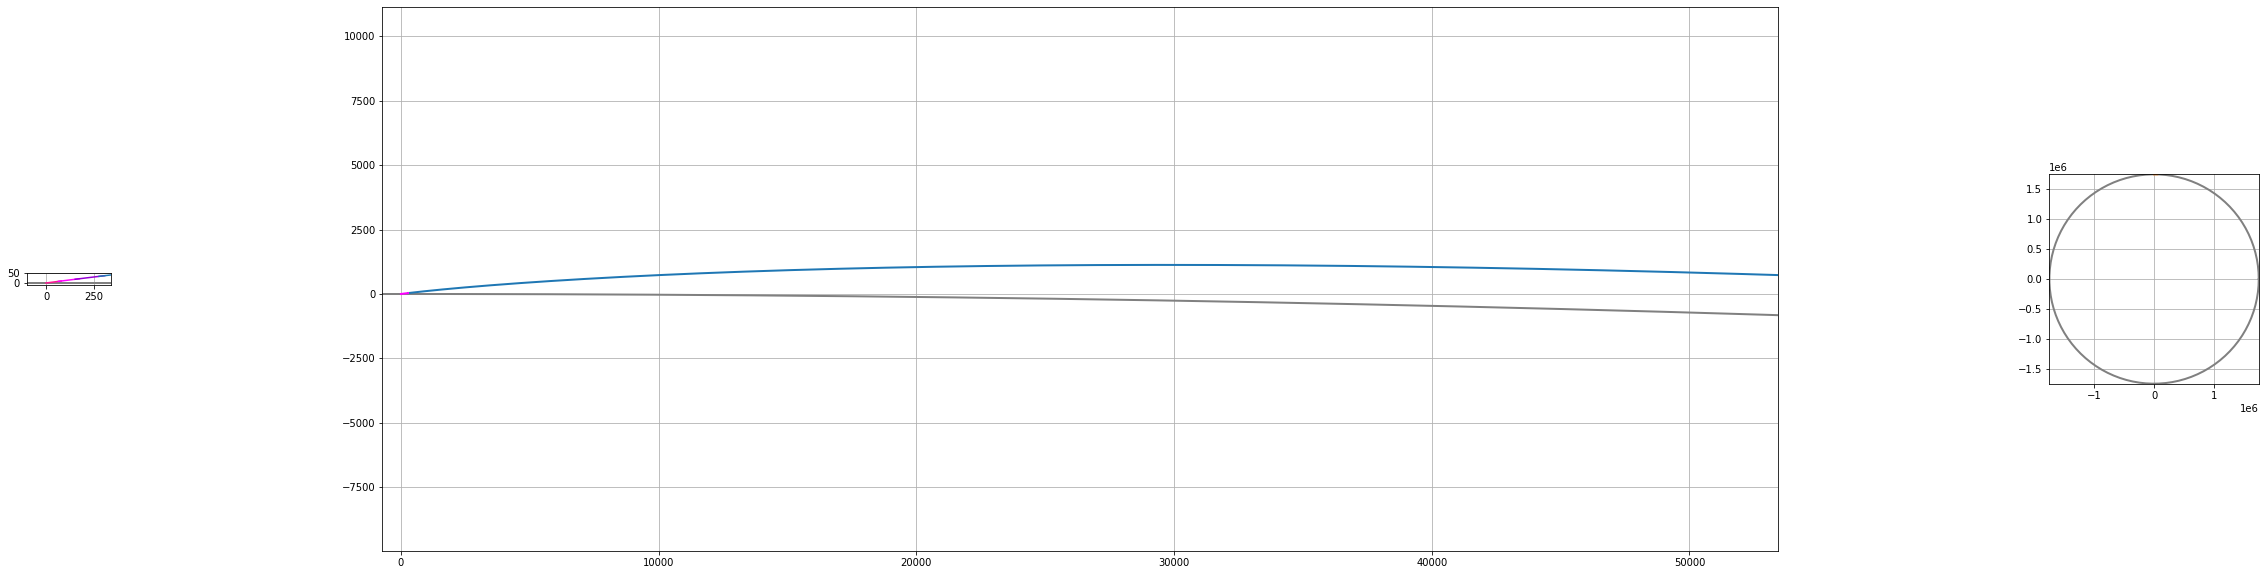

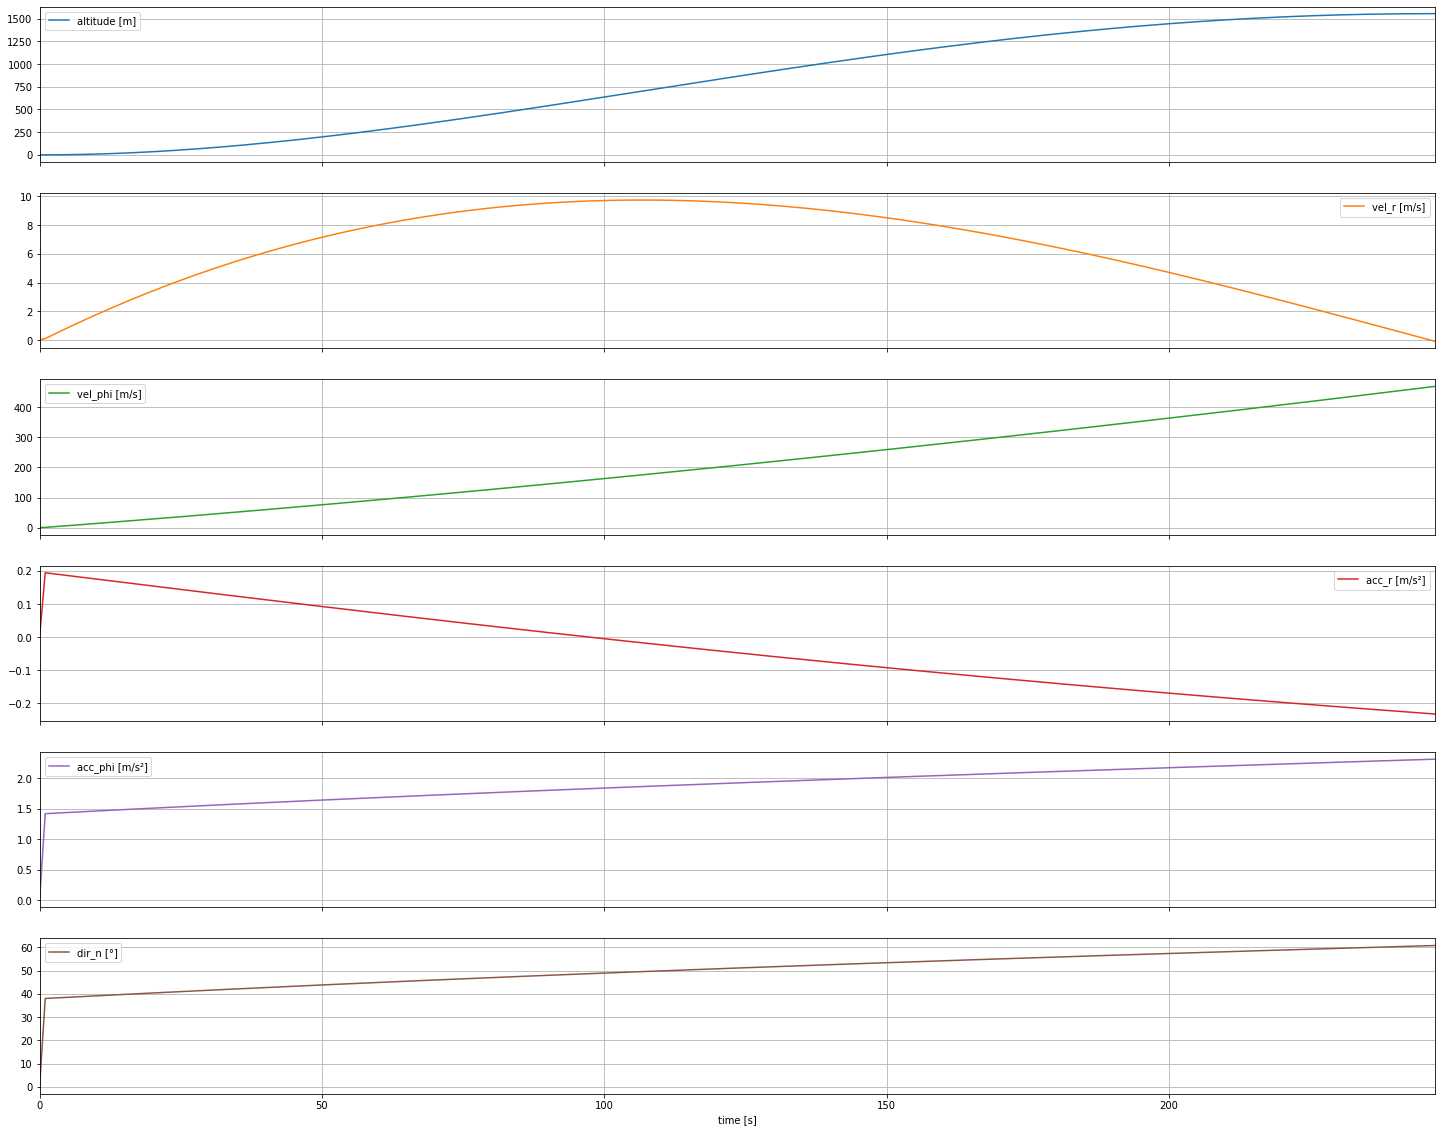

In [210]:
plot_launch_segment(df)

## Grid-Searching Parameter space

In [212]:
a_list = np.arange(200,300,1)
b_list = np.arange(0.003,0.004,0.00001)

print(f'{len(a_list)} x {len(b_list)}')

output = StringIO()
csv_writer = writer(output)
csv_writer.writerow(['a','b','delta_velocity','delta_altitude'])

pbar = tqdm(total=len(a_list)*len(b_list))
for a in a_list:
    for b in b_list:
        result = json.loads(run_sim())
        delta_velocity = result['delta_velocity']
        delta_altitude = result['delta_altitude']
        csv_writer.writerow([a,b,delta_velocity,delta_altitude])
        pbar.update(1)
pbar.close()

output.seek(0)
df = pd.read_csv(output)
file = 'data/grid_search.csv'
df.to_csv(file, index=False)
print(f'result saved to {file}')

100 x 100


  0%|          | 0/10000 [00:00<?, ?it/s]

result saved to data/grid_search.csv


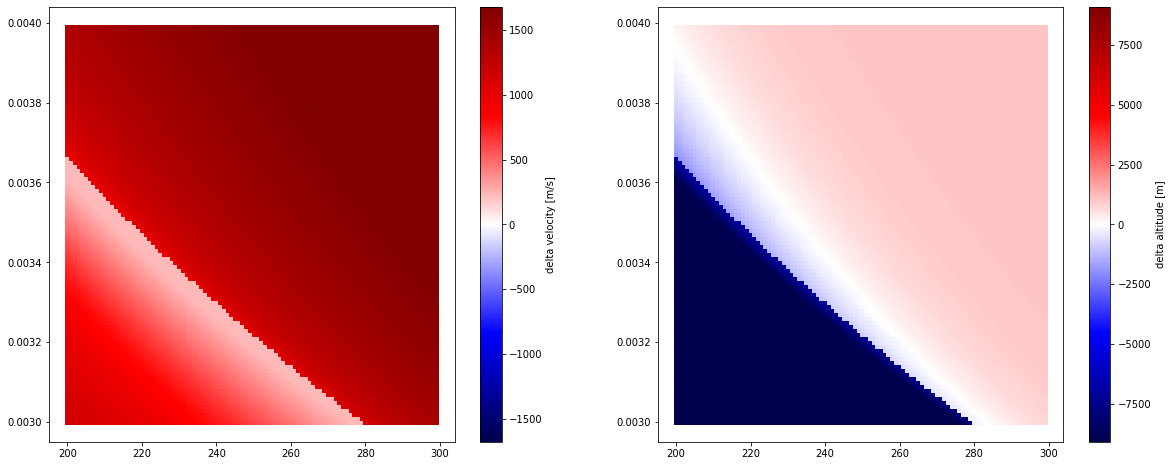

In [219]:
df = pd.read_csv("data/grid_search.csv")
cmap='seismic'

fig, (ax1, ax2) = plt.subplots(figsize=(20, 8), ncols=2)
sc = ax1.scatter(x=df['a'], y=df['b'], c=df['delta_velocity'], cmap=cmap, marker='s', s=15, norm=colors.CenteredNorm())
fig.colorbar(sc, ax=ax1, label='delta velocity [m/s]')

sc = ax2.scatter(x=df['a'], y=df['b'], c=df['delta_altitude'], cmap=cmap, marker='s', s=15, norm=colors.CenteredNorm())
fig.colorbar(sc, ax=ax2, label='delta altitude [m]')
plt.show()

## Precision Solver

In [21]:
max_tries = 1000
tolerance = 10


lin_step = 0.001
fine_step = 0.01
old_input = 1
old_achieve = 1
increase = True

test_range = np.arange(0.001, 0.2, 0.001)
print(len(test_range))

# Parameter Solver
# Achieve target_altitude
for i in range(max_tries):
    
    # ensure that velocity_r gets back to zero as a starting point
    print(f'a: {a} , b: {b}',end='\r')
    vel_r = json.loads(run_sim())['vel_r']
    if abs(vel_r) < 1:
        print()
        print(f"[CHECK] vel_r {vel_r:0.2f} reached.")
        
        # converges delta_altitude = 0
        """
        # begin with interpolation
        b_old = b
        err_old = json.loads(run_sim())['delta_altitude']
        if delta_altitude > 0:
            b -= lin_step
        elif delta_altitude < 0:
            b += lin_step
        err_new = json.loads(run_sim())['delta_altitude']
        # linear guess to get error to 0
        d_err = err_old - err_new
        d_b = b_old - b
        print(f'd_b {d_b}, d_err {d_err}')
        d_b_est = ( err_new / d_err ) * d_b
        b += d_b_est
        """
        
        for i in range(max_tries):
            delta_velocity = json.loads(run_sim())['delta_velocity']
            print(f"[ {i} RUN] vel_r {delta_velocity:0.2f} reached.",end='\r')
            
            if abs(delta_velocity) <= 10:
                print(f"[CHECK] delta_altitude {delta_velocity:0.2f} reached.")
                break
            
            old_value = delta_velocity
            old_input = b
            
            if delta_velocity > 0:
                b += fine_step
            elif delta_velocity < 0:
                b -= fine_step

        break
    else:
        b += 0.01

print()
print(f'a: {a} , b: {b}')

199
a: 1 , b: 0.01
[CHECK] vel_r -0.14 reached.


KeyboardInterrupt: 

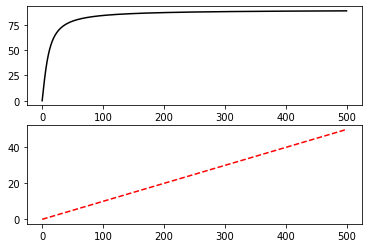

In [75]:
a = 1
b = 0.1

def f(t,rad=False):
    global a, b
    # np.tan(phi)= a - b*t
    phi = np.arctan(b*t)
    if rad: return phi
    else: return np.rad2deg(phi)

t1 = np.arange(0.0, 500, 0.1)

plt.figure()
plt.subplot(211)
plt.plot(t1, f(t1), 'k')

plt.subplot(212)
plt.plot(t1, np.tan(f(t1,rad=True)), 'r--')
plt.show()

## Start Parameter: Ground Elevation

Displacement Map Data: https://svs.gsfc.nasa.gov/4720 

> The displacement map, at 64, 16, and 4 pixels per degree, centered on 0° longitude. Available as either floating-point TIFFs in kilometers, relative to a radius of 1737.4 km, or unsigned 16-bit TIFFs in half-meters, relative to a radius of 1727400 meters.


In [ ]:
# load source .tif file
path = ".\sources\map\heightmap\ldem_64.tif"
height_data = np.array(Image.open(path))

In [ ]:
plot_map(height_data,1,'Height [km]',tuple((-90,90)),tuple((-180,180)),labelsize=10,save="Heightmap.png")

In [ ]:
relative_r = 1737.4 # [km]
img_min = np.amin(height_data)
img_max = np.amax(height_data)
orbit_clearance = 2 # [km]
orbit_radius = (img_max+relative_r) + orbit_clearance # defining orbital radius 2 km above highest point
print(f'Image  extrema:   min:{img_min:10.3f} [km]   max:{img_max:10.3f} [km]')
print(f'Radius extrema:   min:{relative_r+img_min:10.3f} [km]   max:{relative_r+img_max:10.3f} [km]')
print()
print(f'Orbital radius:       {orbit_radius:10.3f} [km]')
print(f'Altitude  gain:   max:{orbit_radius-(relative_r+img_min):10.3f} [km]   min:{orbit_radius-(relative_r+img_max):10.3f} [km]')

### creating initial ground elevation map
break 23040 x 11520 .tif file (64 pixels per degree) <br>
into 1°Lat x 1°Lon tiles (64x64) and perform average <br>
resulting in 360x180 map as input parameter for launch segment

In [ ]:
# helper function
def create_Lat_Lon(resolution):
    # calculation steps in deg for geodetic location

    Longitude = []
    Latitude = []

    for Lon in np.arange(-180+0.5*resolution,180,resolution):
        Longitude.append(Lon)
    for Lat in np.arange(-90+0.5*resolution,90,resolution):
        Latitude.append(Lat)

    Latitude = list(reversed(Latitude))
    
    print('Result map resolution:',len(Longitude),'x',len(Latitude))
    n_total = len(Longitude)*len(Latitude)
    print('number of calculations:',n_total)

    if n_total != int(n_total): print("WARNING: non matching map!")
    
    return Latitude, Longitude

In [ ]:
# initialize result array
Latitude, Longitude = create_Lat_Lon(1)

initial_hight_data = np.zeros((len(Latitude), len(Longitude)))

#print(Latitude)
#print(Longitude)
#print(initial_hight_data)

In [ ]:
# fill result array with tile average

# save variances for paper figure
variances = np.zeros(len(Latitude)*len(Longitude))

for Lat , val in enumerate(tqdm(Latitude)):
    for Lon , val in enumerate(Longitude):
        s_y = Lat * 64 # start
        e_y = s_y + 64 # end
        s_x = Lon * 64 # start
        e_x = s_x + 64 # end
        tile = height_data[s_y:e_y,s_x:e_x]
        variances[Lon+Lat*len(Longitude)] = np.var(tile)
        
        initial_hight_data[Lat][Lon] = np.mean(tile)
        
print('done.')

In [ ]:
# the histogram of the variance
plt.hist(variances, bins=np.arange(0, 3, 0.05), density=True, facecolor='orange',alpha=0.75)

plt.xlabel('Variance')
plt.ylabel('Probability')
plt.title('Histogram of Variance inside a 64x64 Tile')
plt.grid(True)
plt.show()

In [ ]:
# plot Tile samples with minimum, median and maximum variance

def get_tile_from_index(index):
    Lon = int(index%360)
    Lat = int(index/360)

    s_y = Lat * 64 # start
    e_y = s_y + 64 # end
    s_x = Lon * 64 # start
    e_x = s_x + 64 # end

    tile = height_data[s_y:e_y,s_x:e_x]
    
    return tile
    
min_var = np.min(variances)
min_index = np.where(variances == min_var)[0]
max_var = np.max(variances)
max_index = np.where(variances == max_var)[0]
# number of variances is 64800 and therefore equal -> median is not an element of the list but an average
med_var = np.median(variances)
# find element that is closest to the median value
min_delta = 10
med_var_list = 0
for i in variances:
    d = abs(med_var - i)
    if d < min_delta:
        min_delta = d
        med_var_list = i
print(f'closest value to median found with delta to calc median {min_delta}')
med_index = np.where(variances == med_var_list)[0]
print('index', min_index,'min', min_var)
print('index', med_index,'med', med_var)
print('index', max_index,'max', max_var)

tile_min = get_tile_from_index(min_index)
tile_med = get_tile_from_index(med_index)
tile_max = get_tile_from_index(max_index)

minimum = img_min#np.min([tile_min,tile_max])
maximum = img_max#np.max([tile_min,tile_max])

fig, axes = plt.subplots(nrows=3, ncols=2)
im = axes.flat[0].imshow(tile_min, vmin=minimum, vmax=maximum)
im = axes.flat[1].imshow([[np.mean(tile_min)]], vmin=minimum, vmax=maximum)
im = axes.flat[2].imshow(tile_med, vmin=minimum, vmax=maximum)
im = axes.flat[3].imshow([[np.mean(tile_med)]], vmin=minimum, vmax=maximum)
im = axes.flat[4].imshow(tile_max, vmin=minimum, vmax=maximum)
im = axes.flat[5].imshow([[np.mean(tile_max)]], vmin=minimum, vmax=maximum)
axes.flat[0].set_axis_off()
axes.flat[1].set_axis_off()
axes.flat[2].set_axis_off()
axes.flat[3].set_axis_off()
axes.flat[4].set_axis_off()
axes.flat[5].set_axis_off()

fig.subplots_adjust(right=0.6)
cbar_ax = fig.add_axes([0.72, 0.13, 0.05, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [ ]:
im = Image.fromarray((initial_hight_data-img_min)*1000).convert('I')
im.save("downsample.png")

In [ ]:
print(f'from {len(np.ndarray.flatten(initial_hight_data))} entries there are {len(np.unique(initial_hight_data))} unique')
print(initial_hight_data.dtype)
elevation_min = np.amin(initial_hight_data)
elevation_max = np.amax(initial_hight_data)
print(f'min: {elevation_min}')
print(f'max: {elevation_max}')

In [ ]:
plot_map(initial_hight_data,1,'Height [km]',tuple((-90,90)),tuple((-180,180)),labelsize=10,save="Heightmap_downsampled.png")

## Roundtrip considerations
    → Moon surface [load Payload] [refuel O2] → (Launch + Maneuvers) → Destination [refuel H2] [unload Payload] → (Maneuvers + Landing) →

In [ ]:
def calc_mass_flow(mass_full,I_sp):
    # set massflow to reach acceleration from apollo: from vertical rise segment: 10s vertical burn -> 50 ft/s = 15,24 m/s
    # acc moon surface = 1.6242654756205572 [m/s²] <- acc_grav_moon(r_moon)
    a_apollo = 1.6242654756205572 + (15.24/10) # [m/s²]
    g_0 = 9.80665 # [kg/s²] standard gravity
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity
    m_flow = (mass_full * a_apollo) / EEV # [kg/s]
    return m_flow

def maneuver_result_mass(EEV,m_0,deltaV):
    # from: deltaV = EEV * ln ( m_0 / m_f )
    m_f = m_0 * (1/ np.exp(deltaV/EEV))
    return m_f

# roundtrip calculation via deltaV
def compute_roundtrip(mass_full):
    target_altitude = 12757
    mass_dry = 1600
    payload = 1500
    of_ratio = 3
    I_sp = 400 # [s] specific impulse
    g_0 = 9.80665 # [kg/s²] standard gravity
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity
    m_flow = calc_mass_flow(mass_full,I_sp) # [kg/s] massflow
    m_flow = 15
    
    initial_height = -9115 #-8.179428100585938 # lowest point on downsampled map
    mass = mass_full
    fuel = mass_full - mass_dry - payload
    H2_factor = (1/(of_ratio+1))
    O2_factor = (of_ratio/(of_ratio+1))
    H2 = H2_factor * fuel
    O2 = O2_factor * fuel
    
    
    #logging in table
    result_table = PrettyTable([" ", "ΔV", "used fuel", "Δ H2", "Δ O2","mass","fuel left","H2","O2","payload"],float_format = "4.0")
    result_table.set_style(MARKDOWN)
    
    #__________________________________
    # Lunar surface starting condition
    result_table.add_row(["Lunar Surface", "", "", "" , "refill +" , mass, fuel, H2, O2, "+"+str(payload) ])
    
    
    #__________________________________
    # compute launch segemnt
    cmd = "B_Launch_Segment_solver.py" + " single_mode " + str([[0],[0],0.1,mass,initial_height,target_altitude,m_flow]).replace(" ", "")
    print('[shell] python',cmd)
    result = json.loads(subprocess.check_output(cmd, shell=True).decode("utf-8"))
    print(result)
    
    fuel -= result['fuel_used']
    H2 -= H2_factor * result['fuel_used']
    O2 -= O2_factor * result['fuel_used']
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Launch Segment", result['deltaV'], result['fuel_used'], H2_factor * result['fuel_used'], O2_factor * result['fuel_used'], mass, fuel, H2, O2, "" ])
    
    #__________________________________
    # compute orbit segment
    manoeuvre_deltaV = 1000.0
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,manoeuvre_deltaV)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Orbit manoeuvres", manoeuvre_deltaV, fuel_used, H2_factor * fuel_used, O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    #__________________________________
    # Gateway exchange
    
    refill_H2 = 2000
    H2 += refill_H2
    fuel = O2 + H2
    mass = mass_dry + fuel
    
    result_table.add_row(["Gateway exchange", "", "", "+"+str(refill_H2),"", mass, fuel, H2, O2, "-"+str(payload) ])
    
    #__________________________________
    # compute orbit segment return
    
    manoeuvre_deltaV = 1000.0
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,manoeuvre_deltaV)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel
    
    result_table.add_row(["Orbit manoeuvres", manoeuvre_deltaV, fuel_used, H2_factor * fuel_used, O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    #__________________________________
    # compute landing segment return
    cmd = "B_Launch_Segment_solver.py" + " single_mode " + str([[0],[0],0.1,mass,initial_height,target_altitude,m_flow]).replace(" ", "")
    print('[shell] python',cmd)
    result = json.loads(subprocess.check_output(cmd, shell=True).decode("utf-8"))
    print(result)
    
    if O2 < 0:
        result_table.add_row(["Landing Segment", "", "", "" , "" , "", "", "", "OUT OF FUEL", "" ])
    elif H2 < 0:
        result_table.add_row(["Landing Segment", "", "", "" , "" , "", "", "OUT OF FUEL", "", "" ])
    else:
        fuel -= result['fuel_used']
        H2 -= H2_factor * result['fuel_used']
        O2 -= O2_factor * result['fuel_used']
        mass = mass_dry + fuel + payload
        
        result_table.add_row(["Landing Segment", result['deltaV'], result['fuel_used'], H2_factor * result['fuel_used'], O2_factor * result['fuel_used'], mass, fuel, H2, O2, "" ])

    print(result_table)
    print()
    
    

compute_roundtrip(8500)

compute_roundtrip(15000)
    

## modelling the Launch Segment

imitating ascent characteristics from Apollo return flights

> Apollo 11 https://www.hq.nasa.gov/alsj/nasa58040.pdf
<br>
> Apollo 17 https://history.nasa.gov/alsj/a17/A17_MissionReport.pdf

Segmented flight: vertical rise, orbit injection

## call the solver with complete map for 1 deg

In [ ]:
Latitude, Longitude = create_Lat_Lon(1)

In [ ]:
####################################################################################
# WARNING !    this step takes approx. 22 hours to compute for 1 deg resolution    #
####################################################################################
filename = "maps/Launch_Segement"
Latitude, Longitude = create_Lat_Lon(90)
flat_value = len(Longitude)*len(Latitude)
t_step = 0.1
start_mass = 8500
start_height = [1]*flat_value
args = [Longitude,Latitude,t_step,start_mass,start_height]

cmd = "B_Launch_Segment_solver.py" + " " + filename + " " + str(args).replace(" ", "")

start_time = current_milli_time()

result = subprocess.check_output(cmd, shell=True)
print(result.decode("utf-8"))

end_time = current_milli_time()
duration = (end_time - start_time) / 1000
print('finished after',duration / 1000,'[s]')

In [ ]:
# load result array
with xr.open_dataarray("maps/Launch_Segement.nc") as ds:
    xA_result = ds.load()

xA_result

# STK

In [ ]:
# pip install "C:\Program Files\AGI\STK 12\bin\AgPythonAPI\agi.stk12-12.2.0-py3-none-any.whl"
# run this notebook from STK's Python Scripting Interface

In [ ]:
# STK library imports
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
# if using astrogator uncomment the below
# from agi.stk12.stkobjects.astrogator
# if using aviator uncomment the below
# from agi.stk12.stkobjects.aviator

# Python helper library imports
import os
from tqdm.notebook import tqdm
from ipywidgets import *
import time
import numpy as np
import plotly.express as px
import xarray as xr

In [ ]:
# helper functions

# model for launch segment

# plot xArray data

## Destination: Gateway (Near-Rectilinear Halo Orbit)
> open file "Gateway_PROP_Mass_Point.sc" in STK

### connect to STK session and grab elements

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('NRHO_Sat')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

In [ ]:
#satellite  = AgSatellite(root.CurrentScenario.Children.New(AgESTKObjectType.eSatellite,"LeoSat"))
#place_start  = AgPlace(scenario.Children.New(AgESTKObjectType.ePlace,"Start"))

In [ ]:
#def analyse(object):
#    print([method_name for method_name in dir(object)if callable(getattr(object, method_name))])
#print(satellite.Propagator.__dict__.keys())

# use dir() instead

In [ ]:
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
# Name
# FinalValue
# LastUpdate
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
# Name
# CurrentValue
# DesiredValue
# Difference
# Values


# pull data
#print(satellite.Propagator.MainSequence.Item(2).GetResultValue('Eccentricity'))

#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue
#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0).Name

# set data
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).BurnoutVelocity._SetFixedVelocity(1)
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = 44
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0

In [ ]:
#airtemps = xr.tutorial.open_dataset('air_temperature').air.isel(time=500)
#airtemps

In [ ]:
#colorbar_title = results.attrs['var_desc'] + '<br>(%s)'%results.attrs['units']
#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
#fig.show()
#fig.write_image("images/fig1.pdf")
#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print()
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).Name)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000)

#dir(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0))

#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status)

#dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
#dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
#dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
#dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
#dv2 = np.linalg.norm(dv2_vec)
#print(dv2)

### control STK and compute global result

In [ ]:
####################################################################################
# WARNING !    this step takes approx. 4 hours to compute for 5 deg resolution     #
####################################################################################

# calculation steps in deg for geodetic location
resolution = 30

print('Result image resolution:',1+(360/resolution),'x',1+(180/resolution))
n_total = (1+(360/resolution))*(1+(180/resolution))
print('number of calculations:',n_total)

if n_total != int(n_total): print("WARNING: non matching map!")

Longitude = []
Latitude = []

for Lon in range(-180,181,resolution):
    Longitude.append(Lon)
for Lat in range(-90,91,resolution):
    Latitude.append(Lat)


Latitude = list(reversed(Latitude))

deltaV_Gateway = np.zeros((len(Latitude), len(Longitude)))
deltaV_Gateway[:] = np.nan

fuel_mass_Gateway = np.zeros((len(Latitude), len(Longitude)))
fuel_mass_Gateway[:] = np.nan

print()
print(len(Longitude),Longitude)
print()
print(len(Latitude),Latitude)

with tqdm(total=n_total) as pbar:
    for Lat_count, Lat in enumerate(Latitude):
        for Lon_count, Lon in enumerate(Longitude):
            #print("Lat:",Lat,"Lon:",Lon)
            place_start.Position.AssignGeodetic(Lat,Lon,0)
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = Lat
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Longitude = Lon
            if Lon > -90 and Lon < 90:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = -180
            else:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0
                
            satellite.Propagator.RunMCS()
            check1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status
            check2 = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).Status
            if check1 == "Converged" and check2 == "Converged":
                
                # Launch: Burnout.FixedVelocity
                dv1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                # Maneuver: ImpulsiveMnvr.Pointing.Cartesian.X /Y /Z
                dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
                dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
                dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
                dv2 = np.linalg.norm(dv2_vec)

                deltaV_Gateway[Lat_count][Lon_count] = dv2
                fuel_mass_Gateway[Lat_count][Lon_count] = 0
                
            else:
                print("ERROR","did NOT Converge for","Lat:",Lat,"Lon:",Lon)
                
            pbar.update(1)

### save result in xArray

In [ ]:
xA_fuel_mass_Gateway = xr.DataArray(
    data=fuel_mass_Gateway,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Longitude),
        lat=(["lat"], Latitude)
    ),
    attrs=dict(
        description="DeltaV to Gateway",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_fuel_mass_Gateway.to_netcdf("maps/fuel_mass_Gateway.nc")

In [ ]:
# load array
xA_fuel_mass_Gateway = xr.open_dataarray("maps/fuel_mass_Gateway.nc")

In [ ]:
colorbar_title = xA_fuel_mass_Gateway.attrs['var_desc'] + '<br>(%s)'%xA_fuel_mass_Gateway.attrs['units']

#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
fig = px.imshow(img=xA_fuel_mass_Gateway,
                width=1000,
                height=500,
                color_continuous_scale='blugrn_r',
                aspect='equal')

fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
fig.update_yaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-90,-60,-30,0,30,60,90])


fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    title= 'DeltaV Map<br>Destination Gateway',
    title_x=0.45
)


#fig.write_image("fig/dv1.pdf")
fig.write_image("doc/img/dv_Gateway.pdf")
fig.show()


In [ ]:
#print(scenario.StartTime)
#print(scenario.StopTime)

In [ ]:
root.ExecuteCommand('SetState */Satellite/LeoSat Classical TwoBody "' +
                    str(scenario.StartTime) + '" "' + str(scenario.StopTime) +
                    '" 60 ICRF  "' + str(scenario.StartTime) + '" 7200000.0 0.0 90 0.0 0.0 0.0')

In [ ]:
access = satellite.GetAccessToObject(target)
access.ComputeAccess()

In [ ]:
accessDP         = access.DataProviders.Item('Access Data')

results          = accessDP.Exec(scenario.StartTime, scenario.StopTime)

accessStartTimes = results.DataSets.GetDataSetByName('Start Time').GetValues()

accessStopTimes  = results.DataSets.GetDataSetByName('Stop Time').GetValues()

print(accessStartTimes,accessStopTimes)

In [ ]:
accessIntervals = access.ComputedAccessIntervalTimes

dataProviderElements = ['Start Time', 'Stop Time']

for i in range(0,accessIntervals.Count):
    times = accessIntervals.GetInterval(i)
    print(times)

### Retrieve the Satellite Altitude Data From STK

Retrieve and view the altitude of the satellite during an access interval. In the following lines, note how the data providers must follow the data provider folder, sub-folder, and selection.

In [ ]:
satelliteDP       = satellite.DataProviders.Item('LLA State')

satelliteDP2      = satelliteDP.Group.Item('Fixed')

rptElements       = ['Time', 'Lat', 'Lon', 'Alt']

satelliteDPTimeVar = satelliteDP2.ExecElements(accessStartTimes,accessStopTimes, 60, rptElements)

satelliteAltitude = satelliteDPTimeVar.DataSets.GetDataSetByName('Alt').GetValues()

print(satelliteAltitude)

## Destination: Low Lunar Orbit (Equatorial)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Eq')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Low Lunar Orbit (Polar)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Pol')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK